In [1]:
import os
import json
import pandas as pd
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
# import the seaborn stylesheet
import seaborn as sns
sns.set()

from camelsp import Bundesland, util


In [2]:
#nuts = [nt for nt in os.listdir(Bundesland('Hessen').base_path) if nt.startswith('DE')]
nuts = list(util._NUTS_LVL2_NAMES.keys())

In [3]:
# Get the data for all NUTS regions in all Bundesländer
q_list = []
w_list = []
for ID in nuts:
    print(ID)
    with Bundesland(ID) as bl:
        #nuts_ids = bl.nuts_table.nuts_id.values
        
        with warnings.catch_warnings(record=True) as warn:
            for id in bl.metadata.camels_id.values:
                try:
                    data = bl.get_data(id)
                    # only keep data whichi si not empty
                    if not data.empty:
                        # Also check if there are duplicates in the index
                        if not data.index.duplicated().any():
                            q_list.append(data["q"])
                            w_list.append(data["w"])

                except Exception as e:
                    warnings.warn(str(e))

            if len(warn) > 0:
                print(f"There were {len(warn)} warnings (missing data files).")


DE1
DE2
DE3
DE4
There were 364 warnings (missing data files).
DE5
DE6
DE7
DE8
DE9
There were 282 warnings (missing data files).
DEA
There were 209 warnings (missing data files).
DEB
DEC
DED
DEE
There were 80 warnings (missing data files).
DEF
DEG


In [4]:
def merge_series_to_df(series_list):
    """
    Merges a list of pandas series into one dataframe.
    Using index as the key.
    """
    df = pd.concat(series_list, keys=[f's{i+1}' for i in range(len(series_list))], axis=1)
    return df


## Create some graphs

In [5]:
p = '../output_data/metrics'
if not os.path.exists(p):
    os.makedirs(p)

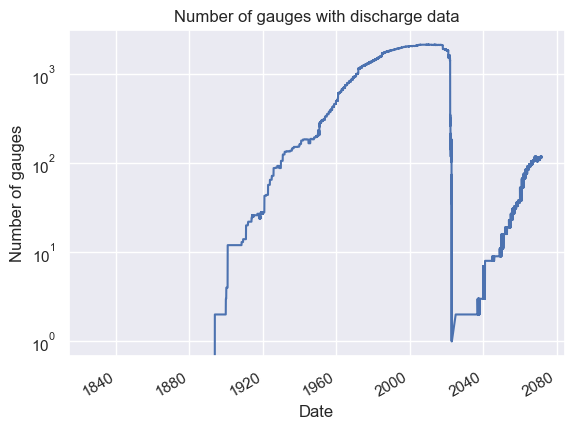

In [6]:
q_df = merge_series_to_df(q_list)
ax = q_df.count(axis=1).plot()
ax.set_ylabel('Number of gauges')
ax.set_xlabel('Date')
ax.set_title('Number of gauges with discharge data')
ax.set_yscale('log')
plt.gcf().savefig(os.path.join(p, 'discharge_gauge_density.pdf'))

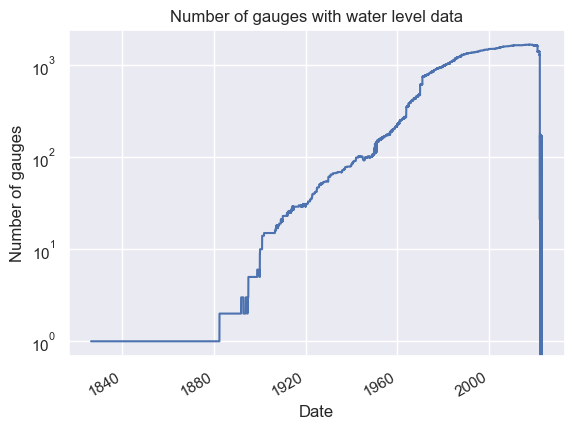

In [7]:
w_df = merge_series_to_df(w_list)
ax = w_df.count(axis=1).plot()
ax.set_ylabel('Number of gauges')
ax.set_xlabel('Date')
ax.set_title('Number of gauges with water level data')
ax.set_yscale('log')
plt.gcf().savefig(os.path.join(p, 'waterlevel_gauge_density.pdf'))

export the graph to a plotly.js figure to use on the website

In [8]:
import plotly.express as px

q_sum = pd.DataFrame(q_df.count(axis=1), columns=['Q gauges'])
w_sum = pd.DataFrame(w_df.count(axis=1), columns=['W gauges'])
 
merge = pd.merge(q_sum, w_sum, left_index=True, right_index=True, how="outer")
fig = px.line(merge)
fig.update_layout(legend=dict(orientation='h'), template='plotly_dark')

with open(os.path.join(p, 'gauge_density.plotly.json'), 'w') as f:
    f.write(fig.to_json())

# add description
with open(os.path.join(p, 'gauge_density.description.json'), 'w') as f:
    json.dump({
        'title': 'CAMELS-de gauge density over time',
        'body': 'The graph shows the amount of active gauges from the CAMELS-de processing dataset over time on daily resolution for water level and discharge each. Note that this graph is generated from the processing dataset that will change over time.',
        'actions': [{'href': 'https://github.com/CAMELS-DE/camelsp/blob/main/scripts/density.ipynb', 'title': 'Resource on Github'}]
    }, f)
